Fant sted: Oslo, Norge
Koordinater: 59.9133301, 10.7389701
Nærmeste værstasjoner:
Stasjons-ID: SN18317, Navn: OSLO - ELVEBAKKEN
Valgte stasjoner: SN18317
Værdata hentet fra Frost API!


/var/folders/qs/xg37mnks64v0t_c9t3m9wxbr0000gn/T/ipykernel_24818/1905306493.py:90: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


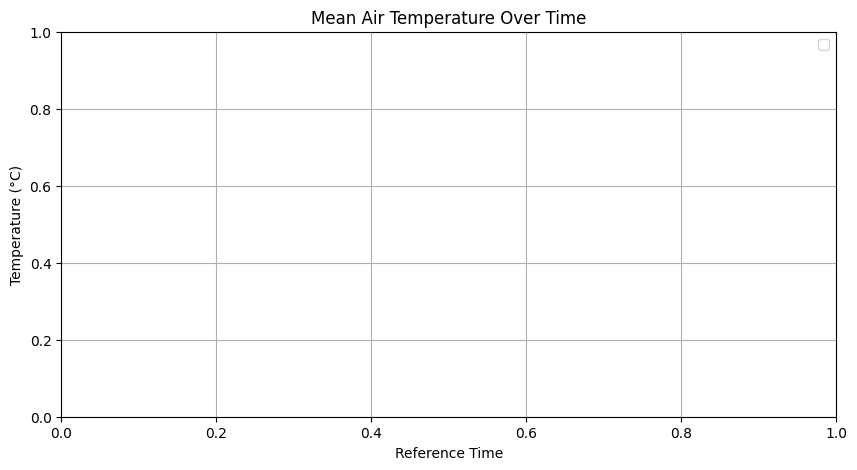

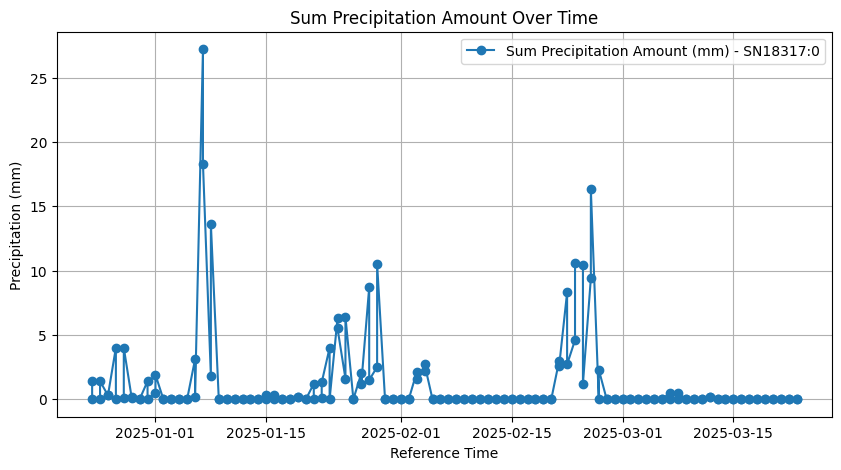

/var/folders/qs/xg37mnks64v0t_c9t3m9wxbr0000gn/T/ipykernel_24818/1905306493.py:112: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


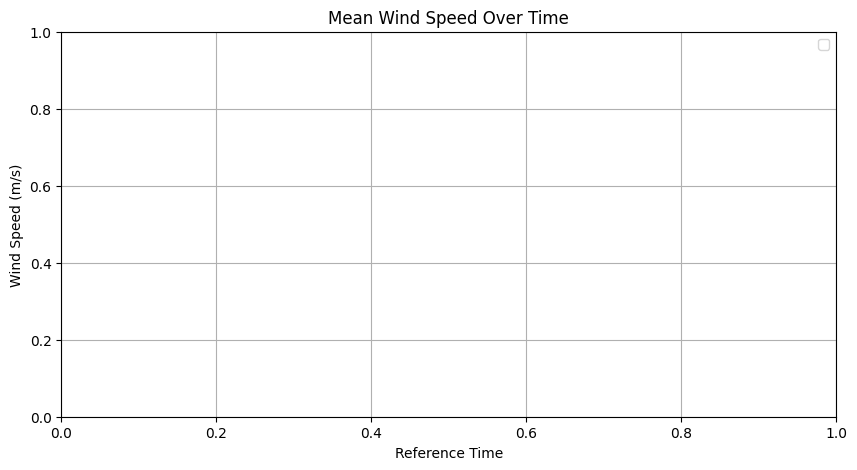

In [10]:
from geopy.geocoders import Nominatim
import requests
import pandas as pd
import matplotlib.pyplot as plt
import os
import certifi
from datetime import datetime, timedelta

# Sett opp SSL-sertifikat
os.environ["SSL_CERT_FILE"] = certifi.where()

# Geopy for å finne koordinater
geolocator = Nominatim(user_agent="Dataanalyseapplikasjon")
place = input("Skriv inn et sted (f.eks. Oslo, Norway): ")
location = geolocator.geocode(place)

if location:
    print(f"Fant sted: {location.address}")
    print(f"Koordinater: {location.latitude}, {location.longitude}")

    # Frost API for å finne stasjoner
    client_id = '2e243d34-57bc-42b4-8095-239991af5353'
    endpoint_sources = 'https://frost.met.no/sources/v0.jsonld'
    parameters_sources = {
        'geometry': f'nearest(POINT({location.longitude} {location.latitude}))',
        'fields': 'id,name,geometry'
    }

    # Send forespørsel til Frost API for stasjoner
    response_sources = requests.get(endpoint_sources, parameters_sources, auth=(client_id, ''))
    if response_sources.status_code == 200:
        sources = response_sources.json()['data']
        print("Nærmeste værstasjoner:")
        station_ids = []
        for source in sources:
            print(f"Stasjons-ID: {source['id']}, Navn: {source['name']}")
            station_ids.append(source['id'])

        # Velg de første to stasjonene for å hente data
        selected_stations = ','.join(station_ids[:2])
        print(f"Valgte stasjoner: {selected_stations}")

        # Frost API for å hente værdata
        endpoint_observations = 'https://frost.met.no/observations/v0.jsonld'
        now = datetime.now()
        offset = now - timedelta(days=90)
        current_date = now.strftime("%Y-%m-%d")
        historic_date = offset.strftime("%Y-%m-%d")

        parameters_observations = {
            'sources': selected_stations,
            'elements': 'mean(air_temperature P1D),sum(precipitation_amount P1D),mean(wind_speed P1D)',
            'referencetime': f'{historic_date}/{current_date}',
        }

        # Send forespørsel til Frost API for observasjoner
        response_observations = requests.get(endpoint_observations, parameters_observations, auth=(client_id, ''))
        if response_observations.status_code == 200:
            data = response_observations.json()['data']
            print("Værdata hentet fra Frost API!")

            # Prosesser data til DataFrame
            df_list = []
            for item in data:
                row = pd.DataFrame(item['observations'])
                row['referenceTime'] = item['referenceTime']
                row['sourceId'] = item['sourceId']
                df_list.append(row)

            df = pd.concat(df_list, ignore_index=True)

            # Plotting av data
            # Filtrer data etter elementId
            temperature_data = df[df['elementId'] == 'mean(air_temperature P1D)']
            precipitation_data = df[df['elementId'] == 'sum(precipitation_amount P1D)']
            wind_speed_data = df[df['elementId'] == 'mean(wind_speed P1D)']

            # Konverter referencetime til datetime
            temperature_data['referenceTime'] = pd.to_datetime(temperature_data['referenceTime'])
            precipitation_data['referenceTime'] = pd.to_datetime(precipitation_data['referenceTime'])
            wind_speed_data['referenceTime'] = pd.to_datetime(wind_speed_data['referenceTime'])

            # Plot mean air temperature
            plt.figure(figsize=(10, 5))
            for source_id, group in temperature_data.groupby('sourceId'):
                plt.plot(group['referenceTime'], group['value'], marker='o', label=f'Mean Air Temperature (°C) - {source_id}')
            plt.xlabel('Reference Time')
            plt.ylabel('Temperature (°C)')
            plt.title('Mean Air Temperature Over Time')
            plt.legend()
            plt.grid(True)
            plt.show()

            # Plot sum precipitation amount
            plt.figure(figsize=(10, 5))
            for source_id, group in precipitation_data.groupby('sourceId'):
                plt.plot(group['referenceTime'], group['value'], marker='o', label=f'Sum Precipitation Amount (mm) - {source_id}')
            plt.xlabel('Reference Time')
            plt.ylabel('Precipitation (mm)')
            plt.title('Sum Precipitation Amount Over Time')
            plt.legend()
            plt.grid(True)
            plt.show()

            # Plot mean wind speed
            plt.figure(figsize=(10, 5))
            for source_id, group in wind_speed_data.groupby('sourceId'):
                plt.plot(group['referenceTime'], group['value'], marker='o', label=f'Mean Wind Speed (m/s) - {source_id}')
            plt.xlabel('Reference Time')
            plt.ylabel('Wind Speed (m/s)')
            plt.title('Mean Wind Speed Over Time')
            plt.legend()
            plt.grid(True)
            plt.show()

        else:
            print(f"Feil ved henting av værdata: {response_observations.status_code}")
            print(f"Melding: {response_observations.json()['error']['message']}")
    else:
        print(f"Feil ved henting av stasjoner: {response_sources.status_code}")
        print(f"Melding: {response_sources.json()['error']['message']}")
else:
    print("Kunne ikke finne stedet. Prøv igjen.")

In [13]:
print(df)

                         elementId  value  unit  \
0        mean(air_temperature P1D)    3.2  degC   
1        mean(air_temperature P1D)    3.0  degC   
2    sum(precipitation_amount P1D)   13.5    mm   
3    sum(precipitation_amount P1D)   29.0    mm   
4             mean(wind_speed P1D)    1.7   m/s   
..                             ...    ...   ...   
325      mean(air_temperature P1D)    2.6  degC   
326      mean(air_temperature P1D)    2.2  degC   
327  sum(precipitation_amount P1D)    1.0    mm   
328  sum(precipitation_amount P1D)    8.6    mm   
329           mean(wind_speed P1D)    5.2   m/s   

                                                 level timeOffset  \
0    {'levelType': 'height_above_ground', 'unit': '...       PT0H   
1    {'levelType': 'height_above_ground', 'unit': '...       PT6H   
2                                                  NaN      PT18H   
3                                                  NaN       PT6H   
4    {'levelType': 'height_above_ground', 

In [16]:
from datetime import datetime, timedelta

now = datetime.now()

one_year_ago = now - timedelta(days=365)

# Hent dagens dato
current_date = datetime.now().date()

# Beregn datoen for ett år siden
date_time_1=one_year_ago.strftime("%Y-%m-%d")

date_time=now.strftime("%Y-%m-%d")

print(type(one_year_ago))
print(date_time_1)
print(type(date_time))

<class 'datetime.datetime'>
2024-03-24
<class 'str'>
